In [1]:
## Data processing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

## Data retrieval imports
import psycopg2
import sys

In [2]:
## Make sure you have pytables installed before running this notebook. 
## If you don't have it, just run "python3 -m pip install tables".

In [3]:
## Declare raw log path and processed output path

H5_PATH = '/home/jovyan/data/Documents/grad-school/abe545-canbus-lab/can/'
EXCEL_CSV_PATH = '/home/jovyan/data/Documents/grad-school/abe545-canbus-lab/excel-csv/'

## Declare event, machine, and date from log

EVENT = 'asm345'
MACHINE_ID = 'j320d'
DATE = '09112021'

## Declare experiment start and end time (UTC Time)

START_TIME = '2021-09-11 00:06:57.0+00' #10:06:57
END_TIME = '2021-09-12 00:10:25.0+00'   #10:10:25

H5_NAME = '-'.join([EVENT, MACHINE_ID, DATE, 'tra.h5'])
EXCEL_CSV_NAME = '-'.join([EVENT, MACHINE_ID, DATE, 'tra-excel.csv'])

SINGLE = True

In [4]:
## Retrieve data from ISOBlue Database

## Define connection parameters
db_host = "172.16.0.9" ## apalis-12 wireguard IP
#db_host = "192.168.10.1" ## apalis-12 wifi IP
db = "casemgnm330-wettshurack-corn21"

param_dic = {
    "host" : db_host,
    "database" : db,
    "user" : "avena",
    "password" : "password"
}

In [5]:
## Define functions to connect and to retrieve a dataframe from a SQL query.

def connect(params_dic):
    """ Connect to the Postgres database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print(f'Connecting to {params_dic["database"]} postgres database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    
    print("Connection successful")
    return conn

## Get query and store as dataframe

def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
        
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tuples
    tuples = cursor.fetchall()
    cursor.close()
    conn.close()
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tuples, columns=column_names)
    return df

In [6]:
## Connect and get the CAN data for the specified interval
conn = connect(param_dic)

column_names = ["time", "can_interface", "can_id", "can_data"]
#column_names = ["time"]
query = f"""SELECT time, can_interface, can_id, can_data 
           FROM can
           WHERE "time" > '{START_TIME}' AND "time" < '{END_TIME}'
        """

can_log = postgresql_to_dataframe(conn, query, column_names)

Connecting to avena-apalis-12 postgres database...
Connection successful


In [7]:
dtypes = {
    'time': str, \
    'can_interface': str, \
    'can_id': str, \
    'can_data': str}

In [8]:
cols = list(dtypes.keys())

In [9]:
datetime_col = [cols[0]]

In [10]:
can_log.head()

,time,can_interface,can_id,can_data
0,2023-04-12 14:10:24.995672+00:00,can0,0CFDD6D5,01000100FFFFFFFF
1,2023-04-12 14:10:24.990069+00:00,can0,18FEEF00,34FFFF00FFFFFFFF
2,2023-04-12 14:10:24.985513+00:00,can0,0CFDD8C9,01000100FFFFFFFF
3,2023-04-12 14:10:24.980669+00:00,can0,18FEDF00,FF8025FFFFFFFFFF
4,2023-04-12 14:10:24.980080+00:00,can0,0CF00400,F0FF8C6425FFFCFF


In [11]:
type(can_log['time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
print(len(can_log))

75747


In [13]:
# Discard rows when `ts` is nan
can_log.dropna(subset=['time'], inplace=True)

In [14]:
can_log['time'][1].timestamp()

1681308624.990069

In [15]:
# Convert UTC timestamp to local time zone
can_log['ts_corr'] = can_log['time'].dt.tz_convert('America/New_York').dt.tz_localize(None)

In [16]:
can_log.head()

,time,can_interface,can_id,can_data,ts_corr
0,2023-04-12 14:10:24.995672+00:00,can0,0CFDD6D5,01000100FFFFFFFF,2023-04-12 10:10:24.995672
1,2023-04-12 14:10:24.990069+00:00,can0,18FEEF00,34FFFF00FFFFFFFF,2023-04-12 10:10:24.990069
2,2023-04-12 14:10:24.985513+00:00,can0,0CFDD8C9,01000100FFFFFFFF,2023-04-12 10:10:24.985513
3,2023-04-12 14:10:24.980669+00:00,can0,18FEDF00,FF8025FFFFFFFFFF,2023-04-12 10:10:24.980669
4,2023-04-12 14:10:24.980080+00:00,can0,0CF00400,F0FF8C6425FFFCFF,2023-04-12 10:10:24.980080


In [17]:
# Assign timezone corrected timestamps as indices
can_log = can_log.set_index('ts_corr')
can_log = can_log.drop(columns=['time', 'can_interface'])
idx = can_log.index
idx.rename('ts', inplace=True)
can_log.rename(columns={'can_data' : 'payload'}, inplace=True)

In [18]:
can_log.head()

,can_id,payload
ts,,
2023-04-12 10:10:24.995672,0CFDD6D5,01000100FFFFFFFF
2023-04-12 10:10:24.990069,18FEEF00,34FFFF00FFFFFFFF
2023-04-12 10:10:24.985513,0CFDD8C9,01000100FFFFFFFF
2023-04-12 10:10:24.980669,18FEDF00,FF8025FFFFFFFFFF
2023-04-12 10:10:24.980080,0CF00400,F0FF8C6425FFFCFF


In [19]:
# ISOBUS message masks
MASK_2_BIT = ((1 << 2) - 1)
MASK_3_BIT = ((1 << 3) - 1)
MASK_8_BIT = ((1 << 8) - 1)

def parse_canid(can_id):
    # J1939 header info:
    # http://www.ni.com/example/31215/en/
    # http://tucrrc.utulsa.edu/J1939_files/HeaderStructure.jpg
    if can_id is None:
        return [-1] * 4
    
    header = int(can_id, 16)

    sa = header & MASK_8_BIT
    header >>= 8
    pdu_ps = header & MASK_8_BIT
    header >>= 8
    pdu_pf = header & MASK_8_BIT
    header >>= 8
    res_dp = header & MASK_2_BIT
    header >>= 2
    priority = header & MASK_3_BIT

    pgn = res_dp
    pgn <<= 8
    pgn |= pdu_pf
    pgn <<= 8
    if pdu_pf >= 240:
        # pdu format 2 - broadcast message. PDU PS is an extension of
        # the identifier
        pgn |= pdu_ps
        da = 255
    else:
        da = pdu_ps
        
    return [pgn, sa, da, priority]

In [20]:
can_log[['pgn', 'sa', 'da', 'pri']] = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan]], index=can_log.index)
can_log.head()

,can_id,payload,pgn,sa,da,pri
ts,,,,,,
2023-04-12 10:10:24.995672,0CFDD6D5,01000100FFFFFFFF,NaN,NaN,NaN,NaN
2023-04-12 10:10:24.990069,18FEEF00,34FFFF00FFFFFFFF,NaN,NaN,NaN,NaN
2023-04-12 10:10:24.985513,0CFDD8C9,01000100FFFFFFFF,NaN,NaN,NaN,NaN
2023-04-12 10:10:24.980669,18FEDF00,FF8025FFFFFFFFFF,NaN,NaN,NaN,NaN
2023-04-12 10:10:24.980080,0CF00400,F0FF8C6425FFFCFF,NaN,NaN,NaN,NaN


In [21]:
# Drop dulicated timestamps (TODO: investigate why)
can_log_f = can_log[~can_log.index.duplicated()]

In [22]:
can_log_f.loc[:, ['pgn', 'sa', 'da', 'pri']] = \
    np.reshape(list(can_log_f['can_id'].apply(lambda x: parse_canid(x)).values), (len(can_log_f),4))

/tmp/ipykernel_827/1195933580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_log_f.loc[:, ['pgn', 'sa', 'da', 'pri']] = \


In [23]:
can_log_f.head()

,can_id,payload,pgn,sa,da,pri
ts,,,,,,
2023-04-12 10:10:24.995672,0CFDD6D5,01000100FFFFFFFF,64982,213,255,3
2023-04-12 10:10:24.990069,18FEEF00,34FFFF00FFFFFFFF,65263,0,255,6
2023-04-12 10:10:24.985513,0CFDD8C9,01000100FFFFFFFF,64984,201,255,3
2023-04-12 10:10:24.980669,18FEDF00,FF8025FFFFFFFFFF,65247,0,255,6
2023-04-12 10:10:24.980080,0CF00400,F0FF8C6425FFFCFF,61444,0,255,3


In [24]:
can_log_p = can_log_f.drop(columns=['can_id'])

In [25]:
if SINGLE:
    pass
else:
    doi = ['2019-07-12', \
          '2019-07-13', \
          '2019-07-14', \
          '2019-07-15', \
          '2019-07-16', \
          '2019-07-17', \
          '2019-07-18', \
          '2019-07-19', \
          '2019-07-20', \
          '2019-07-21', \
          '2019-07-22', \
          '2019-07-23', \
          '2019-07-24', \
          '2019-07-25']

    t_start = '01:00:00'
    t_end = '23:59:59'

In [26]:
if SINGLE:
    can_log_p.to_hdf(H5_PATH + H5_NAME, key='df', mode='w')
else:
    pass #TODO: fix to_hdf path
    for d in tqdm(doi):
        c = can_log_p.loc[(d + ' ' + t_start):(d + ' ' + t_end), :]
        if c.empty:
            continue
        c.to_hdf('../data/jkwh-290-' + d + '.h5', key='df', mode='w')

In [27]:
### FINISH RAW CSV TO H5 CONVERSION ###

In [28]:
### BEGIN H5 TO EXCEL CSV FILE CONVERSION ###

In [29]:
h5_log = pd.read_hdf(H5_PATH + H5_NAME)

In [30]:
h5_log.head()

,payload,pgn,sa,da,pri
ts,,,,,
2023-04-12 10:10:24.995672,01000100FFFFFFFF,64982,213,255,3
2023-04-12 10:10:24.990069,34FFFF00FFFFFFFF,65263,0,255,6
2023-04-12 10:10:24.985513,01000100FFFFFFFF,64984,201,255,3
2023-04-12 10:10:24.980669,FF8025FFFFFFFFFF,65247,0,255,6
2023-04-12 10:10:24.980080,F0FF8C6425FFFCFF,61444,0,255,3


In [31]:
h5_log['ts'] = h5_log.index

In [32]:
h5_log.head()

,payload,pgn,sa,da,pri,ts
ts,,,,,,
2023-04-12 10:10:24.995672,01000100FFFFFFFF,64982,213,255,3,2023-04-12 10:10:24.995672
2023-04-12 10:10:24.990069,34FFFF00FFFFFFFF,65263,0,255,6,2023-04-12 10:10:24.990069
2023-04-12 10:10:24.985513,01000100FFFFFFFF,64984,201,255,3,2023-04-12 10:10:24.985513
2023-04-12 10:10:24.980669,FF8025FFFFFFFFFF,65247,0,255,6,2023-04-12 10:10:24.980669
2023-04-12 10:10:24.980080,F0FF8C6425FFFCFF,61444,0,255,3,2023-04-12 10:10:24.980080


In [33]:
h5_log['ts'] = h5_log['ts'].apply(lambda x: x.timestamp())

In [34]:
h5_log.to_csv(EXCEL_CSV_PATH + EXCEL_CSV_NAME, index=False)

In [35]:
## END H5 TO EXCEL CSV CONVERSION ##

In [36]:
## BEGIN DATA VALIDATION ##

In [37]:
can_log = pd.read_hdf(H5_PATH + H5_NAME)

In [38]:
pgns = {
    61444: {'bytes': list(range(32,40)) + list(range(24,32)), 'offset': 0, 'resolution': 0.125, 'name': 'Engine RPM', 'unit': 'RPM'},
    65266: {'bytes': list(range(8,16)) + list(range(0,8)), 'offset': 0, 'resolution': 0.05, 'name': 'Fuel Rate', 'unit': 'L/h'},
    65128: {'bytes': range(0,8), 'offset': -40.0, 'resolution': 1.0, 'name': 'Hydraulic Temp', 'unit': 'degree C'}}

In [39]:
def hex2bin(hex_str):
    scale = 16 # equals to hexadecimal
    num_of_bits = 64
    return str(bin(int(hex_str, scale))[2:].zfill(num_of_bits))

def map2col(n, payload_bin_str):
    bin_vals = list(payload_bin_str)
    return bin_vals[n]

Working on PGN 61444
Mapping ...
Done
Working on PGN 65266
Mapping ...
Done
Working on PGN 65128
Mapping ...
Done


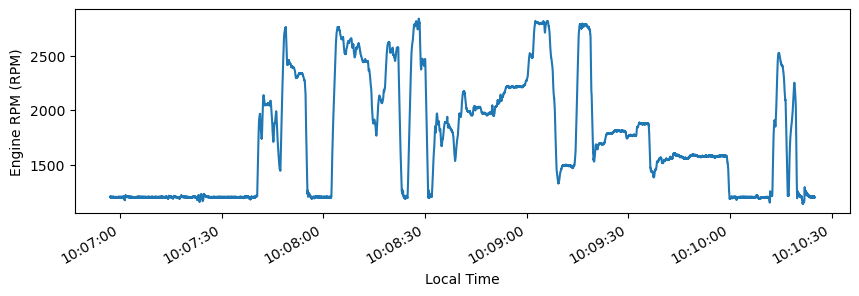

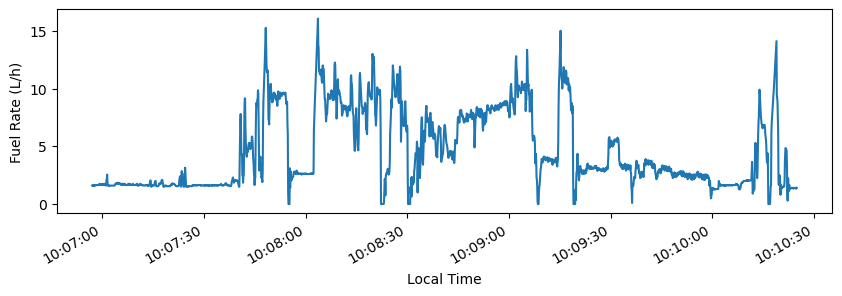

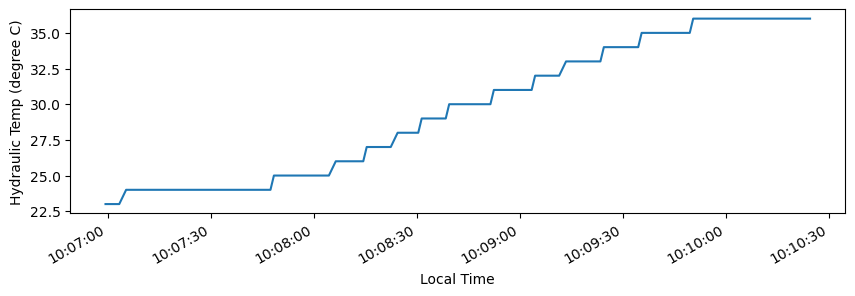

In [40]:
for pgn, d in pgns.items():
    print('Working on PGN {}'.format(pgn))
    log_f = can_log[can_log['pgn'] == pgn]
    bins = log_f['payload'].apply(lambda x: hex2bin(x))
    bins_col = pd.DataFrame()
    print('Mapping ...')
    for n in range(64):
        bins_col[n] = bins.apply(lambda x: map2col(n, x))
    print('Done')
    bins_col = bins_col.astype(int)
    s_dec = bins_col[d['bytes']].astype(str).apply(lambda x: int((''.join(x)), 2) * d['resolution'] + d['offset'], axis=1)
#     s_dec_s = s_dec.resample('1s').mean()
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(s_dec.index, s_dec.values)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
    ax.set_xlabel('Local Time')
    ax.set_ylabel('{} ({})'.format(d['name'], d['unit']))
    #ax.set_xlim(left=pd.Timestamp("2021-11-11 15:50:00"), right=pd.Timestamp("2021-11-11 15:56:00"))